<a href="https://colab.research.google.com/github/shadab77/DNN/blob/main/time_series_forecasting_CNN1D_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all necessary library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import pickle
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
df = pd.read_csv('/content/sample_data/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-08-22,244.832306,246.515991,243.826080,244.379013,244.379013,4611500
1,2008-08-25,242.147369,247.572037,239.850983,240.603165,240.603165,4043600
2,2008-08-26,240.827316,240.827316,234.416351,236.194687,236.194687,6641100
3,2008-08-27,235.980484,236.528427,231.552094,233.415100,233.415100,8807000
4,2008-08-28,235.362808,237.335403,234.286835,236.005386,236.005386,6082000


## Remove date and volume columns from data <b>
## Split data into train and test sample

In [2]:
df_date = df[['Date']]
df.drop(['Date', 'Volume'], axis=1, inplace=True)
train, test = df[0:2700], df[2700:]
print(df.shape)
print(train.shape)
print(test.shape)

(2998, 5)
(2700, 5)
(298, 5)


#####Apply scaling on x and y of train data 

In [3]:
def data_preprocessing(dataset, columns, filename):
  fn = preprocessing.StandardScaler()
  dataset[columns] = fn.fit_transform(dataset[columns])
  pickle.dump(fn, open('./' + filename, 'wb'))
  return dataset

cols_y = ['Open']
cols_x = [x for x in train.columns if x not in cols_y]

df_new_train = data_preprocessing(train, cols_x, 'x_StandardScaler')
df_new_train = data_preprocessing(df_new_train, cols_y, 'y_StandardScaler')
df_new_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

,Open,High,Low,Close,Adj Close
0,-1.002388,-1.004160,-0.997368,-1.003230,-1.003230
1,-1.011059,-1.000778,-1.010313,-1.015417,-1.015417
2,-1.015322,-1.022381,-1.028011,-1.029646,-1.029646
3,-1.030975,-1.036150,-1.037339,-1.038617,-1.038617
4,-1.032970,-1.033565,-1.028433,-1.030257,-1.030257


#### Apply transformation on test data

In [4]:
imputer_x = pickle.load(open('x_StandardScaler','rb'))
imputer_y = pickle.load(open('y_StandardScaler','rb'))
def data_transformation(object, dataset, columns):
    dataset[columns] = object.transform(dataset[columns])
    return dataset

df_new_test = data_transformation(imputer_x, test, cols_x)
df_new_test = data_transformation(imputer_y, df_new_test, cols_y)
df_new_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,Open,High,Low,Close,Adj Close
2700,1.967777,2.011916,1.995436,2.013337,2.013337
2701,1.980566,1.986260,1.986221,1.959500,1.959500
2702,1.903154,1.879430,1.893191,1.883812,1.883812
2703,1.916039,1.898363,1.914348,1.918606,1.918606
2704,1.910420,1.916979,1.940238,1.924383,1.924383


Create the window data which will have 30(60, 90, etc..) days of past and will predict next 7(30, 60, 90, etc..) days of future

In [5]:
df_new_train = train
df_new_test = test

def multivar_ts(df, x_step, y_step):
  x, y = [], []
  
  for i in range(len(df)):
    end_df = i + x_step
    if end_df > len(df) - y_step:    # this step control the shape of array 
      break
    else:
      x.append(df[i:end_df, :])
      y.append(df[end_df:end_df+y_step, 0])
  
  return x, y
x_train, y_train = multivar_ts(df_new_train.to_numpy(), x_step = 30, y_step = 7)

In [6]:
x_test, y_test = multivar_ts(df_new_test.to_numpy(), x_step = 30, y_step = 7)
print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)

(2664, 30, 5)
(2664, 7)
(262, 30, 5)
(262, 7)


In [7]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape[0])
print(x_train.shape[1])
print(x_train.shape[2])

2664
30
5


##### Apply 1D Convulution and Two LSTM layers Before passing it into dense layers

In [8]:
x_step = 30

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=2,
                      activation="relu", input_shape=(x_step, x_train.shape[2])),
  tf.keras.layers.LSTM(32, activation="relu", return_sequences=True),
  tf.keras.layers.LSTM(32, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 32)            352       
_________________________________________________________________
lstm (LSTM)                  (None, 29, 32)            8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0

In [9]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=256, verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


11/11 [==============================] - 4s 126ms/step - loss: 0.3500 - mae: 0.6956 - val_loss: 1.8480 - val_mae: 2.3480
Epoch 2/100
11/11 [==============================] - 1s 66ms/step - loss: 0.2498 - mae: 0.5093 - val_loss: 1.1342 - val_mae: 1.6342
Epoch 3/100
11/11 [==============================] - 1s 65ms/step - loss: 0.1126 - mae: 0.3264 - val_loss: 0.8736 - val_mae: 1.3536
Epoch 4/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0689 - mae: 0.2499 - val_loss: 0.7511 - val_mae: 1.1994
Epoch 5/100
11/11 [==============================] - 1s 64ms/step - loss: 0.0486 - mae: 0.2090 - val_loss: 0.2873 - val_mae: 0.6712
Epoch 6/100
11/11 [==============================] - 1s 65ms/step - loss: 0.0484 - mae: 0.2084 - val_loss: 0.1469 - val_mae: 0.4752
Epoch 7/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0429 - mae: 0.1970 - val_loss: 0.2077 - val_mae: 0.5764
Epoch 8/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0440 - mae:

In [10]:
acc_tr = model.evaluate(x_train, y_train)
acc_te = model.evaluate(x_test, y_test)
print(acc_tr, acc_te)

9/9 [==============================] - 0s 7ms/step - loss: 0.0931 - mae: 0.3907
[0.004276640247553587, 0.06105867400765419] [0.09308377653360367, 0.39067521691322327]


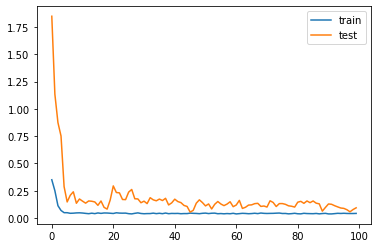

In [11]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=256, verbose=1, callbacks=[es])

Epoch 1/100
11/11 [==============================] - 1s 71ms/step - loss: 0.0370 - mae: 0.1831 - val_loss: 0.0751 - val_mae: 0.3455
Epoch 2/100
11/11 [==============================] - 1s 67ms/step - loss: 0.0395 - mae: 0.1896 - val_loss: 0.1071 - val_mae: 0.4222
Epoch 3/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0395 - mae: 0.1925 - val_loss: 0.1249 - val_mae: 0.4607
Epoch 4/100
11/11 [==============================] - 1s 67ms/step - loss: 0.0374 - mae: 0.1820 - val_loss: 0.1402 - val_mae: 0.4874
Epoch 5/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0411 - mae: 0.1972 - val_loss: 0.1093 - val_mae: 0.4297
Epoch 6/100
11/11 [==============================] - 1s 68ms/step - loss: 0.0390 - mae: 0.1873 - val_loss: 0.1083 - val_mae: 0.4253
Epoch 7/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0387 - mae: 0.1881 - val_loss: 0.1005 - val_mae: 0.4114
Epoch 8/100
11/11 [==============================] - 1s 75ms/step - loss: 0.

In [13]:
acc_tr = model.evaluate(x_train, y_train)
acc_te = model.evaluate(x_test, y_test)
print(acc_tr, acc_te)

9/9 [==============================] - 0s 7ms/step - loss: 0.1114 - mae: 0.4354
[0.005906988866627216, 0.07090221345424652] [0.11135175824165344, 0.4353775978088379]


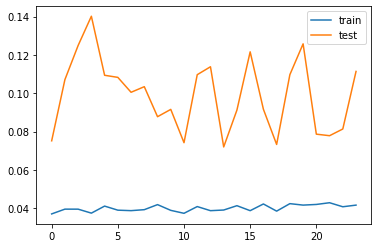

In [14]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
train_pred = model.predict(x_train)
train_pred.shape

(2664, 1)

In [16]:
z = np.zeros(36)
z_new = np.append(z, train_pred)
z_new.shape

(2700,)

####Apply prediction on Train data - Initial values are zero because these are the starting points of data and same goes with test data as well


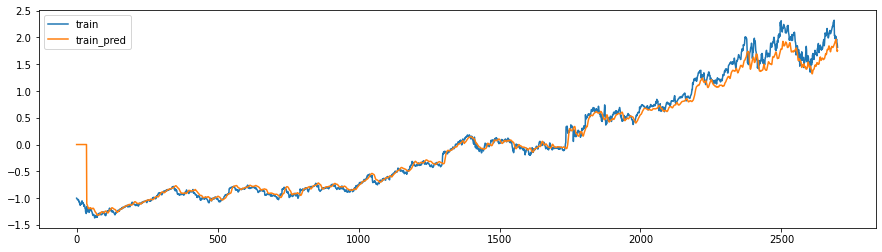

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(df_new_train['Open'], label='train')
plt.plot(z_new, label='train_pred')
plt.legend()
plt.show()

In [18]:
test_pred = model.predict(x_test)
test_pred.shape

(262, 1)

In [19]:
#498-462
z = np.zeros(36)
z_new_test = np.append(z, test_pred)
z_new_test.shape

(298,)

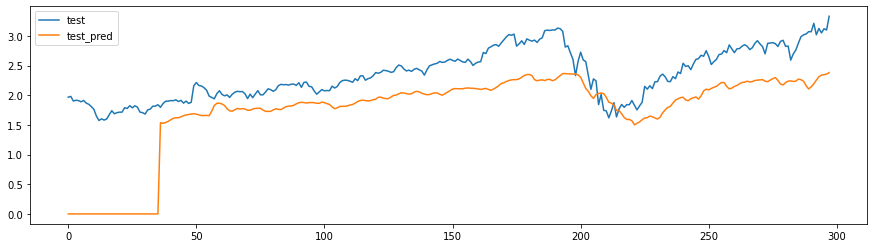

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(df_new_test['Open'].tolist(), label='test')
plt.plot(z_new_test, label='test_pred')
plt.legend()
plt.show()